In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from models import BDRE, MDRE, TPE


N_DIMS = 1 # Number of dimensions
NUM_SAMPLES = 10 # Number of samples per distribution (if 3 distributions, then 3 x 33000)
BS = 64 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 44
GAMMA = 1 / 2
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
#     f = (6*x - 2)**2 * np.sin(3*x - 4)
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return f

In [4]:
dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
dense_y = forrester(dense_x, noise=False)

In [5]:
X_obs = np.random.uniform(-1, 2, (10, 1))
y_obs = forrester(X_obs, noise=True)
tau = np.quantile(y_obs, q=GAMMA)

In [6]:
def split_good_bad(X, y, gamma):
    tau = np.quantile(np.unique(y), q=gamma)
    z = np.less(y, tau).flatten()

    return X, y, z, tau

In [7]:
from botorch.utils.sampling import draw_sobol_samples

def prepare_data_bdre(X_obs, y_obs, gamma):
    X_obs = torch.tensor(X_obs, **tkwargs)
    y_obs = torch.tensor(y_obs, **tkwargs)

    tau = torch.quantile(y_obs, q=gamma)
    z_obs = torch.less(y_obs, tau).flatten()

    x_p, y_p = X_obs[z_obs], y_obs[z_obs]
    w_p = (tau - y_obs)[z_obs]
    # w_p = w_p / torch.mean(w_p)
    z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)

    x_q, y_q = X_obs[~z_obs], y_obs[~z_obs]
    w_q = torch.empty(x_q.shape[0], 1, dtype=X_obs.dtype).fill_(1)
    z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)

    x_train = torch.cat([x_p, x_q], axis=0)
    y_train = torch.cat([y_p, y_q], axis=0)
    z = torch.cat([z_p, z_q], axis=0)
    z_train = torch.nn.functional.one_hot(z).to(X_obs.dtype)
    w_train = torch.cat([w_p, w_q], axis=0)
    w_train = w_train / w_train.mean()
    return x_train, y_train, z_train, w_train, tau

def prepare_data_mdre(X_obs, y_obs, gamma):
    X_obs = torch.tensor(X_obs, **tkwargs)
    y_obs = torch.tensor(y_obs, **tkwargs)

    tau = torch.quantile(y_obs, q=gamma)
    z_obs = torch.less(y_obs, tau).flatten()

    x_p, y_p = X_obs[z_obs], y_obs[z_obs]
    x_q, y_q = X_obs[~z_obs], y_obs[~z_obs]
    x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]]), n=len(x_p), q=1).squeeze(1)
    y_m = forrester(x_m, noise=False)

    z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
    z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
    z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)

    s_p = x_p.shape[0]
    s_q = x_q.shape[0]
    s_m = x_m.shape[0]

    w_p = (tau - y_obs)[z_obs].squeeze(1)
    # w_p = w_p / torch.mean(w_p)
    w_p = w_p * (s_p + s_q + s_m) / s_p
    w_q = z_q * (s_p + s_q + s_m) / s_q
    w_m = torch.tensor(len(z_m) * [ (s_q + s_p + s_m) / s_m]).to(X_obs.dtype)

    x_train = torch.cat([x_p, x_q, x_m], axis=0)
    y_train = torch.cat([y_p, y_q, y_m], axis=0)
    z = torch.cat([z_p, z_q, z_m], axis=0)
    z_train = torch.nn.functional.one_hot(z).to(X_obs.dtype)
    w_train = torch.cat([w_p, w_q, w_m], axis=0)
    w_train = w_train / w_train.mean()
    return x_train, y_train, z_train, w_train, tau

In [8]:
def plot_step_through_tpe(X_obs, y_obs, z_obs, new_x, new_y, tau, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    # tpe
    x_p = X_obs[z_obs]
    y_p = y_obs[z_obs]
    x_q = X_obs[~z_obs]
    y_q = y_obs[~z_obs]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('TPE')

    good_density = np.exp(tpe.kde_good.score_samples(dense_x))
    bad_density = np.exp(tpe.kde_bad.score_samples(dense_x))
    ax_func.fill_between(
        dense_x.flatten(),
        good_density,
        0,
        facecolor="#d627283f",
        edgecolor="#d62728",
        label=r"$\ell(x)$",
    )
    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    
    ax_func.fill_between(
        dense_x.flatten(),
        bad_density,
        0,
        facecolor="#1f77b43f",
        edgecolor="#1f77b4",
        label=r"$g(x)$",
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
#     ax_func.legend()

    ax_acf.fill_between(
        dense_x.flatten(),
        acf,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

    
def plot_step_through_bdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]

    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('BDRE')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )

    ax_acf.plot(dense_x, dr)
    # ax_acf.fill_between(
    #     dense_x.flatten(),
    #     dr,
    #     0,
    #     facecolor="#2ca02c3f",
    #     edgecolor="#2ca02c",
    #     label=r"$\ell(x)$",
    # )
    ax_acf.set_xlim(-1, 2)
    # ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')


def plot_step_through_mdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]
    x_m = X_obs[z_obs[:, 2].bool()]
    
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 2], s=1, color='tab:green',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('MDRE')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
    ax_func.plot(
        x_m,
        np.zeros(len(x_m)),
        '|',
        markersize=12,
        color="tab:green"
    )

    ax_acf.plot(dense_x, dr)
    # ax_acf.fill_between(
    #     dense_x.flatten(),
    #     dr,
    #     0,
    #     facecolor="#2ca02c3f",
    #     edgecolor="#2ca02c",
    #     label=r"$\ell(x)$",
    # )
    ax_acf.set_xlim(-1, 2)
    # ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

def plot_step_through_lfbo(X_obs, y_obs, new_x, new_y, acf_mean, acf_samples, ax_func, ax_acf):
    X_obs_rff, y_obs_rff, z_obs_rff, tau = split_good_bad(X_obs, y_obs, gamma=GAMMA)
    acf_std = torch.std(acf_samples, axis=0).numpy()

    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs_rff[z_obs_rff]
    y_p = y_obs_rff[z_obs_rff]
    x_q = X_obs_rff[~z_obs_rff]
    y_q = y_obs_rff[~z_obs_rff]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    # ax_func.scatter(dense_x, acf_mean + 2 * acf_std, s=1, color='tab:red',)
    # ax_func.scatter(dense_x, 1-acf_samples, s=1, color='tab:blue',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('LFBO_RFF')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
    ax_acf.plot(
        dense_x,
        acf_mean.reshape(dense_x.shape),
        c='k',
        label="mean",
    )
    for n, posterior_sample in enumerate(acf_samples):
        ax_acf.plot(
            dense_x,
            posterior_sample.reshape(dense_x.shape),
            alpha=.6,
            label='posterior samples' if n<1 else None
        )
        if n > 5:
            break

    ax_acf.fill_between(
        dense_x.flatten(),
        (acf_mean+2*acf_std).ravel(),
        (acf_mean-2*acf_std).ravel(),
        color="tab:gray",
        alpha=0.3,
        label="confidence interval",
    )
    
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

In [9]:
import math
from typing import Optional
from collections import OrderedDict

import torch
from torch import Tensor
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.distributions import MultivariateNormal
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.utils.transforms import t_batch_mode_transform
from botorch.sampling.normal import SobolQMCNormalSampler

class Posterior(GPyTorchPosterior):
    def __init__(self, distribution, phi_rffs) -> None:
        super().__init__(distribution=distribution)
        self.phi_rffs = phi_rffs

    def rsample_from_base_samples(
        self,
        sample_shape: torch.Size,
        base_samples: Tensor,
    ) -> Tensor:
        # n x b x q x o
        samples = super().rsample_from_base_samples(sample_shape=sample_shape, base_samples=base_samples)
        # n x q x b x o
        posterior_samples = torch.sigmoid(torch.matmul(self.phi_rffs.unsqueeze(2), samples).transpose(1, 2))
        # n x b x q x o
        return posterior_samples

    def rsample(
        self,
        sample_shape: Optional[torch.Size] = None,
        base_samples: Optional[Tensor] = None,
    ) -> Tensor:
        samples = super().rsample(sample_shape=sample_shape, base_samples=base_samples)
        posterior_samples = torch.sigmoid(
            torch.matmul(self.phi_rffs[None, ...], samples)
        )
        return posterior_samples

    @property
    def mean(self) -> Tensor:
        r"""The posterior mean."""
        mean = self.distribution.mean
        # multiply the mean by the RFFs
        # add q dimension b x q x d
        # switch q and b: q x b x d
        posterior_mean = torch.matmul(self.phi_rffs, mean.transpose(0, 1))

        # switch back q
        # posterior_mean = posterior_mean.transpose(1, 0).squeeze(1)
        return torch.sigmoid(posterior_mean)

    @property
    def variance(self) -> Tensor:
        r"""The posterior variance."""
        variance = self.distribution.variance
        if not self._is_mt:
            variance = variance.unsqueeze(-1)
        return variance


class RFF_MLP(torch.nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        num_hidden_units,
        num_rffs,
        num_hidden_layers,
        dropout_rate=0.0,
        device="cpu:0",
        dtype=torch.double,
    ) -> None:
        super().__init__()
        self.tkwargs = {"dtype": dtype, "device": device}

        layers = []
        layers.append((f"input_layer", torch.nn.Linear(input_dim, num_hidden_units)))
        layers.append((f"input_activation", torch.nn.ReLU()))
        layers.append((f"dropout", torch.nn.Dropout(dropout_rate)))
        for i in range(num_hidden_layers):
            layers.append((f"hidden_layer_{i}", torch.nn.Linear(num_hidden_units, num_hidden_units)))
            layers.append((f"activation_{i}", torch.nn.ReLU()))
            layers.append((f"dropout_{i}", torch.nn.Dropout(dropout_rate)))
        self.layers = torch.nn.Sequential(OrderedDict(layers))

        # RFF layer
        # m
        self.num_rffs = num_rffs
        # w
        self.register_buffer("weights", torch.randn(size=(self.num_rffs, num_hidden_units)))
        # b
        self.register_buffer("bias", torch.rand(self.num_rffs) * 2 * torch.pi)

        self.blr_layer = torch.nn.Linear(
            num_rffs,
            output_dim,
            bias=False,
        )
        # prior distribution of the weights in the blr layer: N(0, I)
        self.blr_layer.weight.data.normal_(0.0, 1.0)
        # precision matrix is simply the inverse of covariance matrix
        self.intialize_precision_matrix()

    def intialize_precision_matrix(self):
        self.precision_matrix = torch.nn.parameter.Parameter(
            torch.eye(self.num_rffs, **self.tkwargs),
            requires_grad=False
        )
        self.register_parameter('precision_matrix', self.precision_matrix)

    def update_precision_matrix(self, phi_rffs, logits, y, w):
        y_pred = torch.sigmoid(logits)
        # this coefficient only appear when using the LFBO loss, i.e. weighted classification
        coef = (y * w + 1.).view(y_pred.shape)
        precision_matrix_batch_update = torch.sum(
                                            coef * \
                                            y_pred * (1 - y_pred) * \
                                            torch.matmul(phi_rffs.transpose(2, 1), phi_rffs),
                                            axis=0
                                        )
        self.precision_matrix.data += precision_matrix_batch_update

    def compute_covariance_matrix(self):
        # default is lower triangle matrix
        L = torch.linalg.cholesky(self.precision_matrix)
        self.Sigma_N = torch.cholesky_inverse(L)

    def rffs_layer(self, phi):
        # input phi has dimension: num_obs x 1 x num_rffs 
        # phi_rffs = sqrt(2a/m) * cos(wx+b)
        return (
            torch.sqrt(torch.tensor(2.0 / self.weights.shape[0])) *
            torch.cos(torch.matmul(phi, self.weights.t()) + self.bias)
        )

    def forward(self, X, y=None, w=None):
        # Residual Feedfoward Network
        # first pass through input layer
        phi = self.layers[0](X)
        # hidden residual block
        for i in range(1, len(self.layers) - 2):
            if isinstance(self.layers[i], torch.nn.Linear):
                identity = phi
                phi = self.layers[i](phi)
                phi += identity
            else:
                phi = self.layers[i](phi)
        phi = self.layers[-2](phi)  # feature layer
        phi = self.layers[-1](phi)  # activation
        
        # RFF layers
        phi_rffs = self.rffs_layer(phi)
        logits = self.blr_layer(phi_rffs)

        if self.training:
            self.update_precision_matrix(phi_rffs, logits, y, w)
        return logits, phi_rffs

    def check_input_dims(self, X):
        # check if X has batch dimension
        if len(X.shape) == 1:
            X = X[..., None, None]
        elif len(X.shape) == 2:
            X = X[:, None, :]
        # X should have: num_obs x n_dim x 1
        return X
    
    @staticmethod
    def split_good_bad(X, y, gamma, acq_type='ei'):
        tau = torch.quantile(torch.unique(y), q=gamma)
        z = torch.less(y, tau)

        if len(X) > 1 and acq_type == 'ei':
            z_idx = z.squeeze()

            x1, z1 = X[z_idx], z[z_idx].to(X.dtype)
            x0, z0 = X, torch.zeros_like(z).to(X.dtype)

            w1 = (tau - y)[z_idx]
            # sometimes w1 is empty
            w1 = w1 / torch.mean(w1) if len(w1) else w1
            w0 = 1 - z0

            x = torch.concat([x1, x0], axis=0)
            z = torch.concat([z1, z0], axis=0)
            s1 = x1.shape[0]
            s0 = x0.shape[0]

            w = torch.concat([w1 * (s1 + s0) / s1, w0 * (s1 + s0) / s0], axis=0)
            w = w / torch.mean(w)

        elif len(X) == 1 or acq_type == 'pi':
            x = X
            w = torch.ones_like(z).to(X.dtype)

        return x, y, z, w
    
    def fit(self, X, y, gamma, batch_size=256, S=50):
        X = self.check_input_dims(X)

        new_X, _, z, w = self.split_good_bad(X.detach(), y.detach(), gamma=gamma)

        # add batch dim
        train_tensor = [new_X, z.unsqueeze(1), w.unsqueeze(1)]
        train_dataset = torch.utils.data.TensorDataset(*train_tensor)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))

        N = len(X)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        optimizer = torch.optim.Adam(self.parameters())
        # update the models
        self.train()
        for epochs in range(E):
            self.intialize_precision_matrix()
            for _, (inputs, targets, weights) in enumerate(train_dataloader):
                optimizer.zero_grad(set_to_none=True)

                outputs, _ = self(inputs, targets, weights)
                batch_mle_loss = torch.nn.functional.binary_cross_entropy_with_logits(
                    outputs, targets, weight=weights
                )
                for param in self.blr_layer.parameters():
                    if param.requires_grad:
                        batch_reg_loss = 0.5 * torch.matmul(param, param.t()).view_as(batch_mle_loss)
                batch_loss = batch_mle_loss + batch_reg_loss / M
                batch_loss.backward()
                optimizer.step()
        self.eval()
        # compute the updated covariance matrix
        self.compute_covariance_matrix()

    def posterior(self, X):
        self.eval()  # make sure model is in eval mode
        # X: b x q x d
        if len(X.size()) == 2:
            X = X.unsqueeze(0)

        # with torch.no_grad():
        _, phi_rffs = self(X)

        # 1 x num_rffs
        # batch_shape x event shape
        w_map = self.blr_layer.weight.data
        mvn = MultivariateNormal(
            w_map, self.Sigma_N
        )
        posterior = Posterior(distribution=mvn, phi_rffs=phi_rffs)
        return posterior


class qUpperConfidenceBound(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        beta,
        weights,
        sampler=None,
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # MCAcquisitionFunction performs some validity checks that we don't want here
        super(MCAcquisitionFunction, self).__init__(model=model)
        if sampler is None:
            sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))
        self.sampler = sampler
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform()
    def forward(self, X):
        """Evaluate scalarized qUCB on the candidate set `X`.

        Args:
            X: A `(b) x q x d`-dim Tensor of `(b)` t-batches with `q` `d`-dim
                design points each.

        Returns:
            Tensor: A `(b)`-dim Tensor of Upper Confidence Bound values at the
                given design points `X`.
        """
        # switch q and b dimension
        X = X.transpose(0, 1)

        posterior = self.model.posterior(X)
        samples = self.get_posterior_samples(posterior)  # n x b x q x o
        scalarized_samples = samples.matmul(self.weights)  # n x b x q
        mean = posterior.mean  # b x q x o
        scalarized_mean = mean.matmul(self.weights)  # b x q
        # ucb_samples = (
        #     scalarized_mean
        #     + math.sqrt(self.beta * math.pi / 2)
        #     * (scalarized_samples - scalarized_mean).abs()
        # )
        # return ucb_samples.mean(dim=1).squeeze()
        scalarized_std = scalarized_samples.std(dim=0)
        return (scalarized_mean + self.beta.sqrt() * scalarized_std).squeeze()

100%|██████████| 500/500 [00:01<00:00, 476.35it/s]


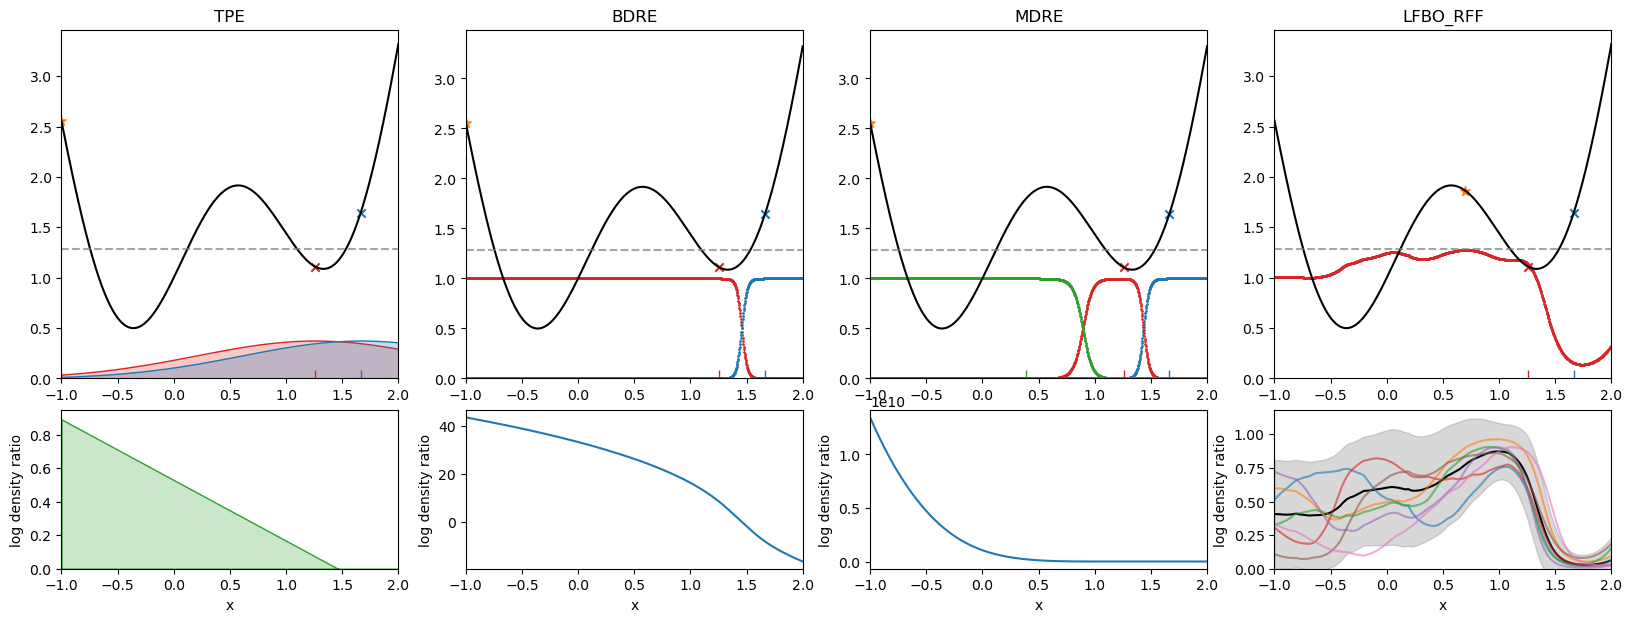

100%|██████████| 500/500 [00:01<00:00, 466.35it/s]


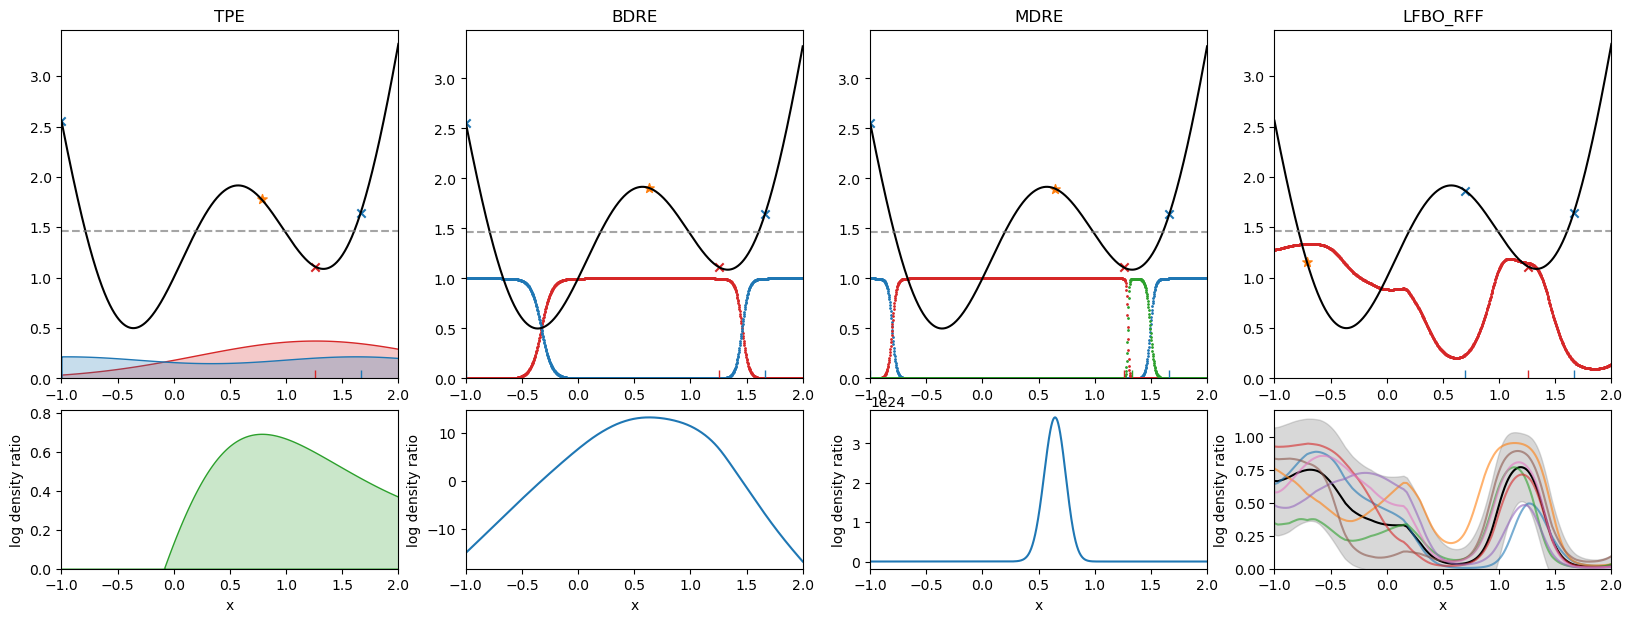

100%|██████████| 500/500 [00:01<00:00, 311.98it/s]


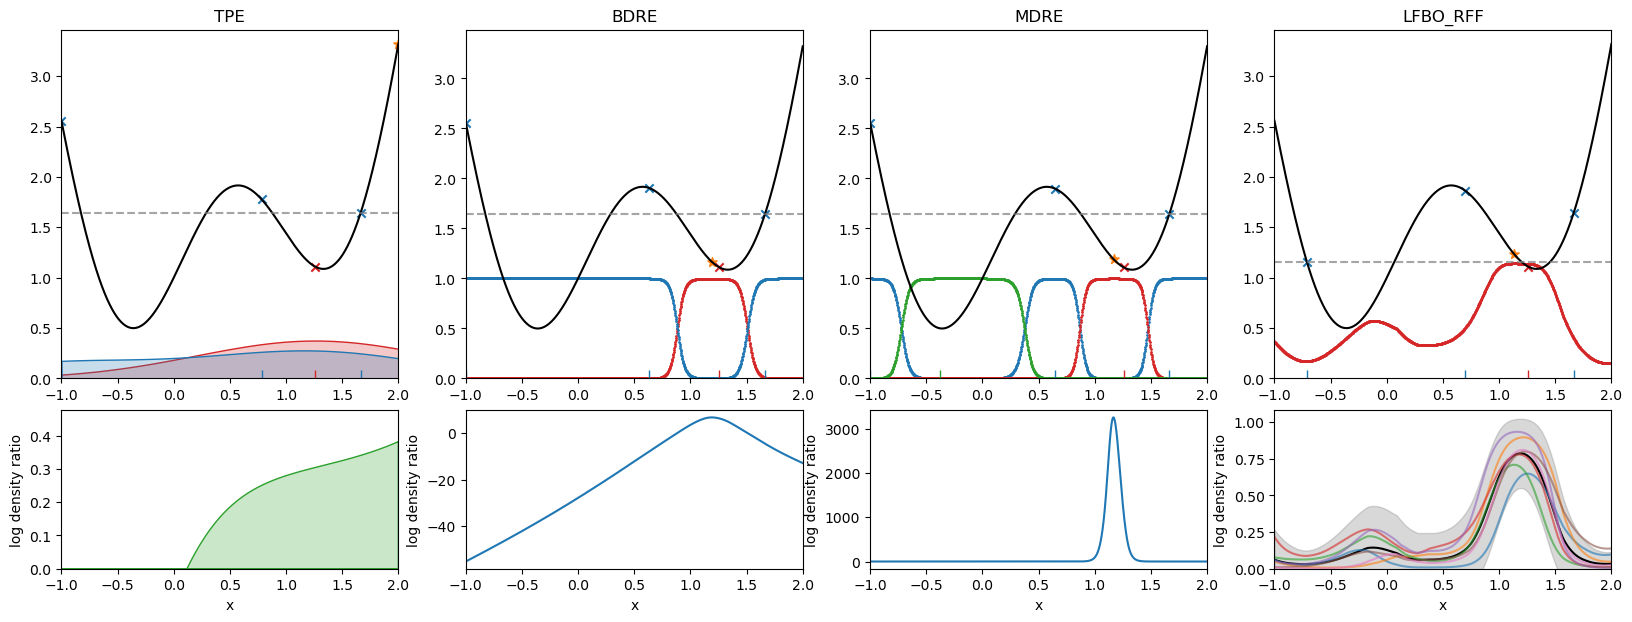

100%|██████████| 500/500 [00:01<00:00, 463.71it/s]


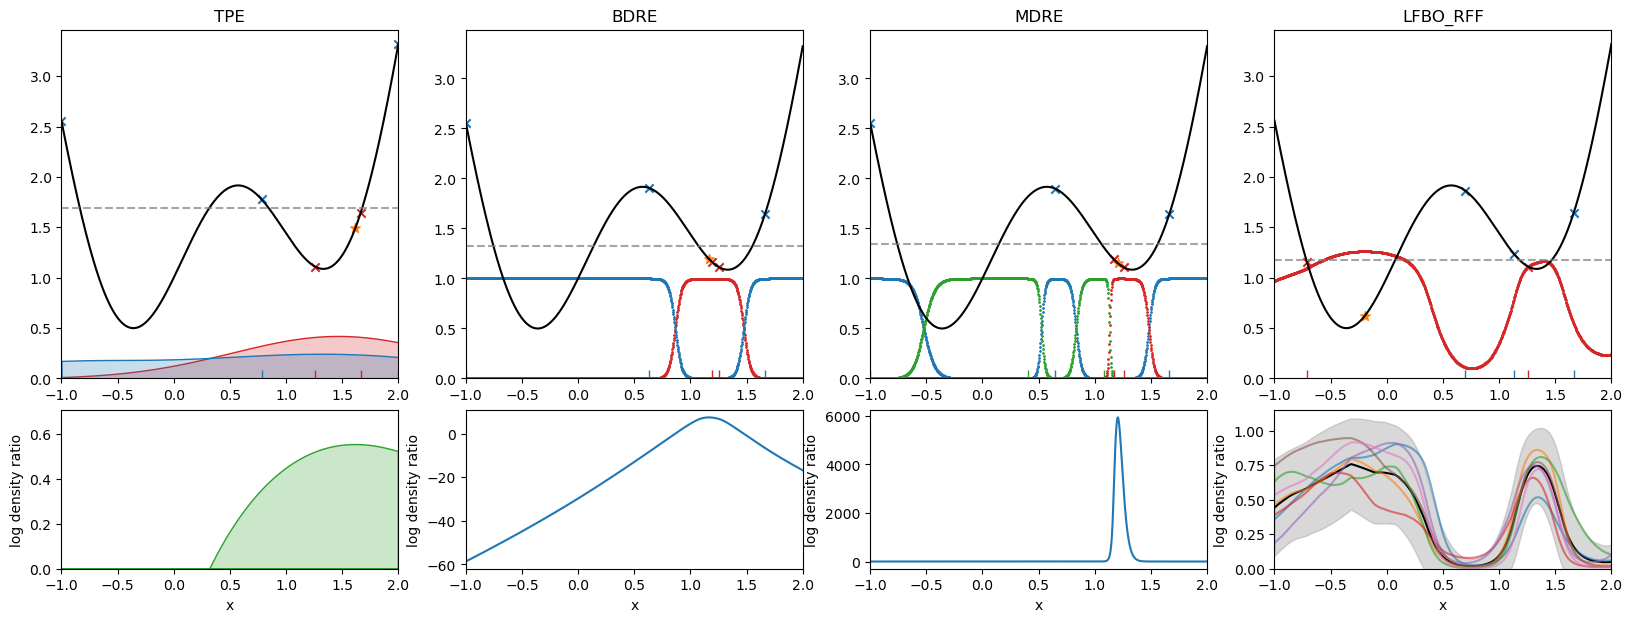

100%|██████████| 500/500 [00:01<00:00, 482.86it/s]


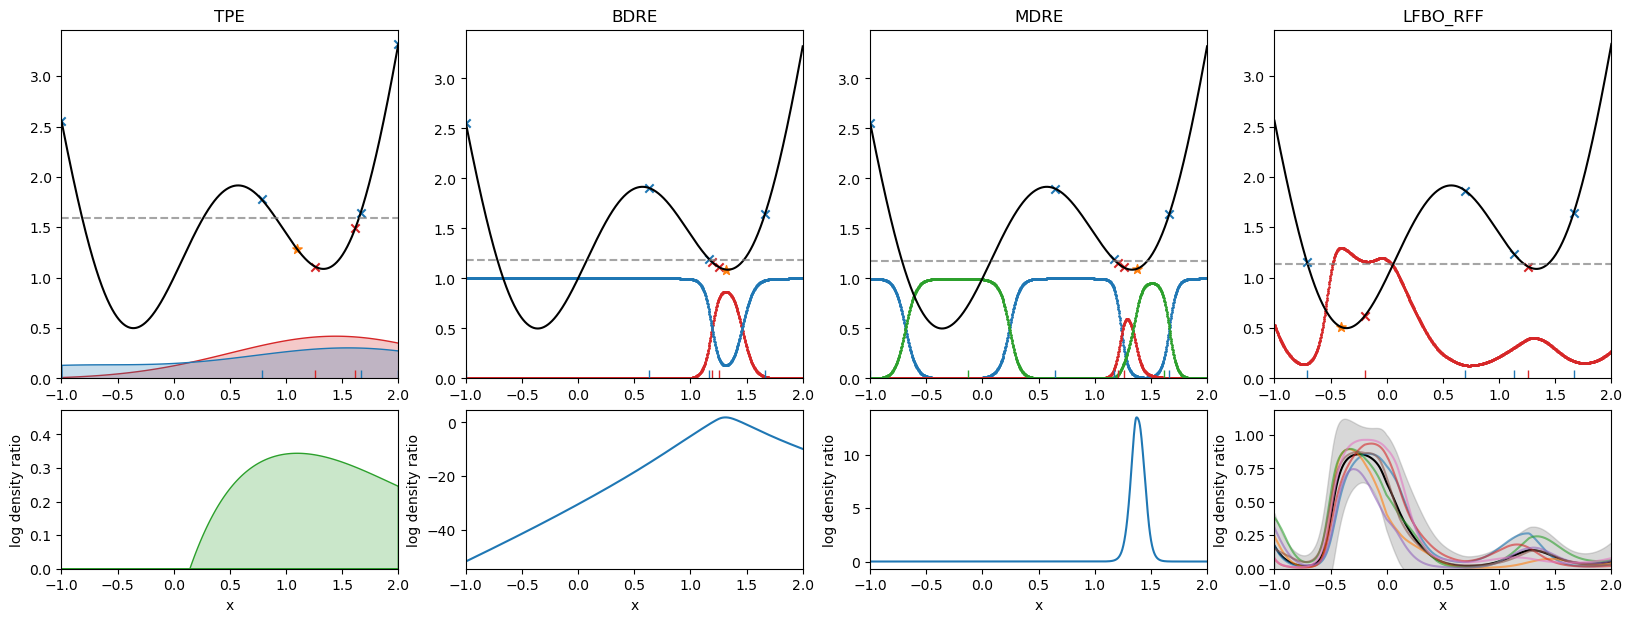

100%|██████████| 500/500 [00:01<00:00, 413.97it/s]


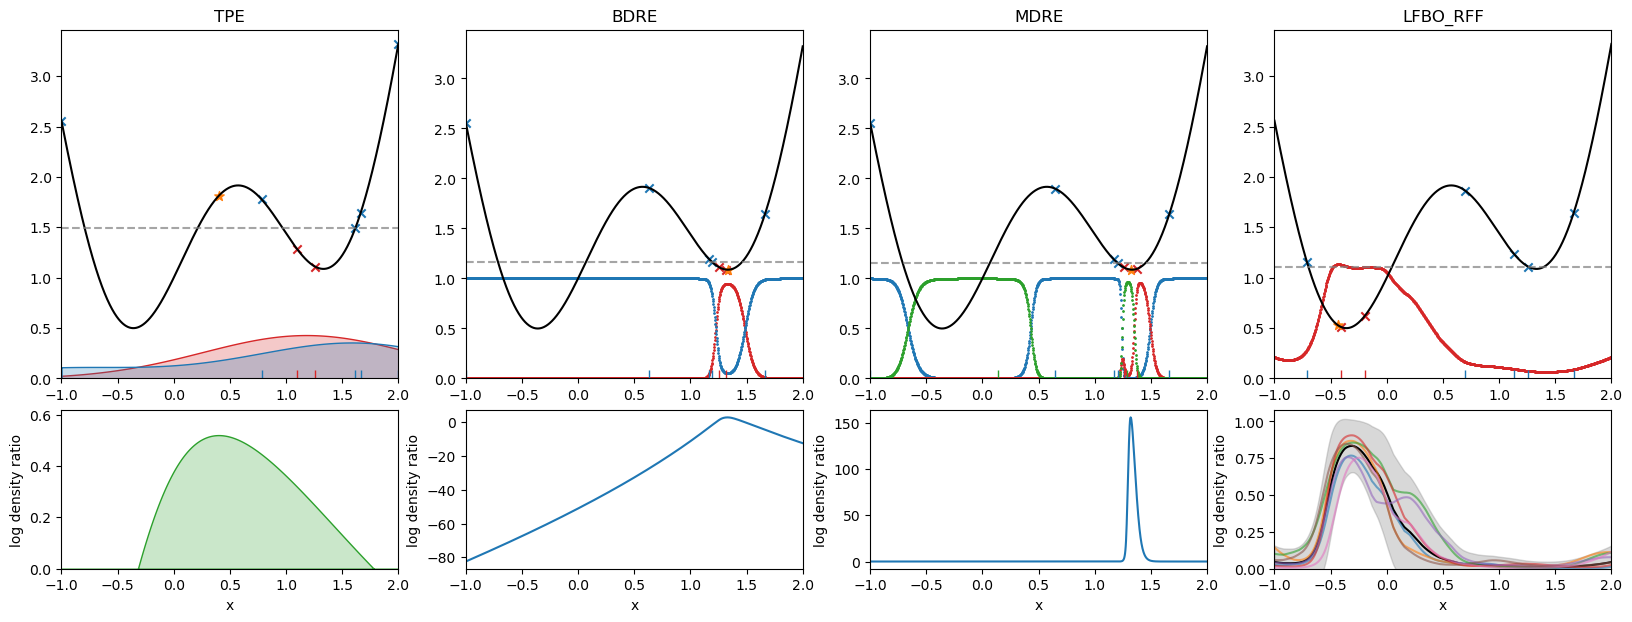

100%|██████████| 500/500 [00:01<00:00, 434.05it/s]


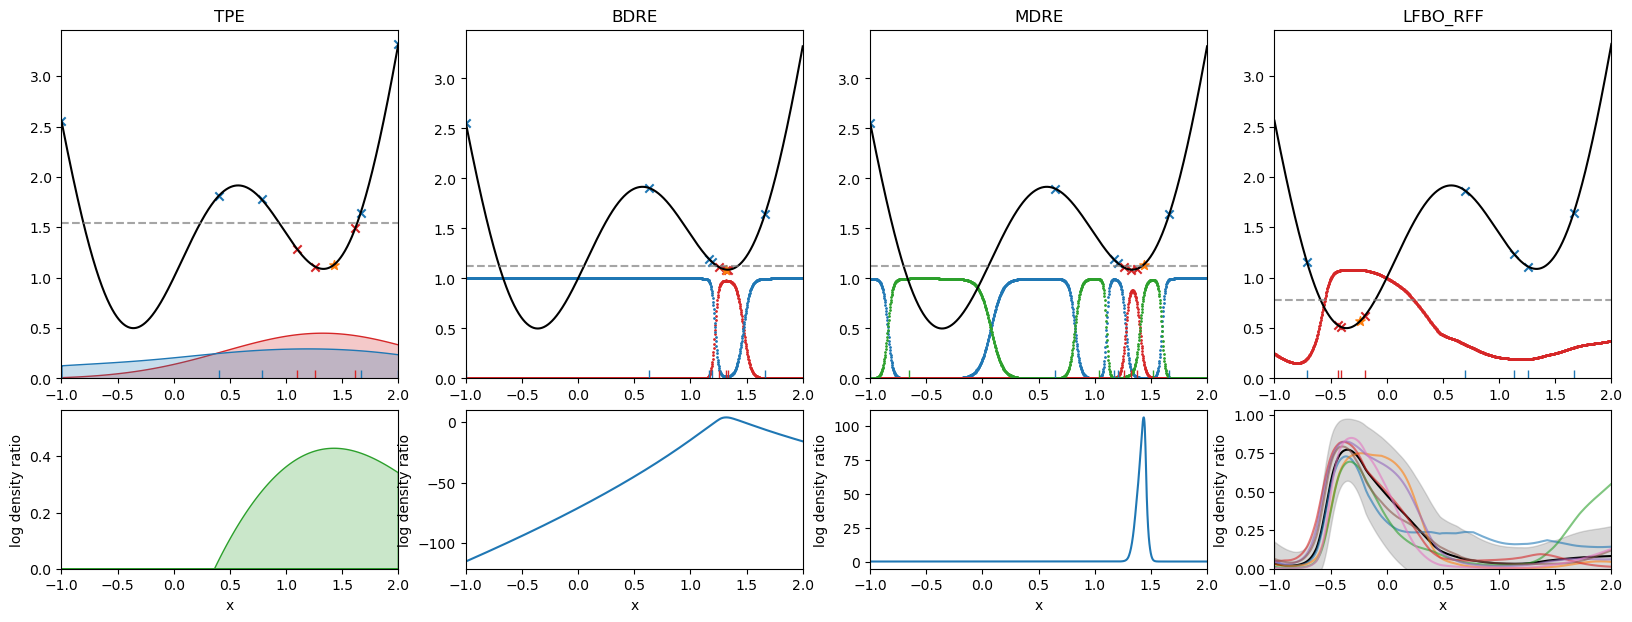

100%|██████████| 500/500 [00:01<00:00, 424.43it/s]


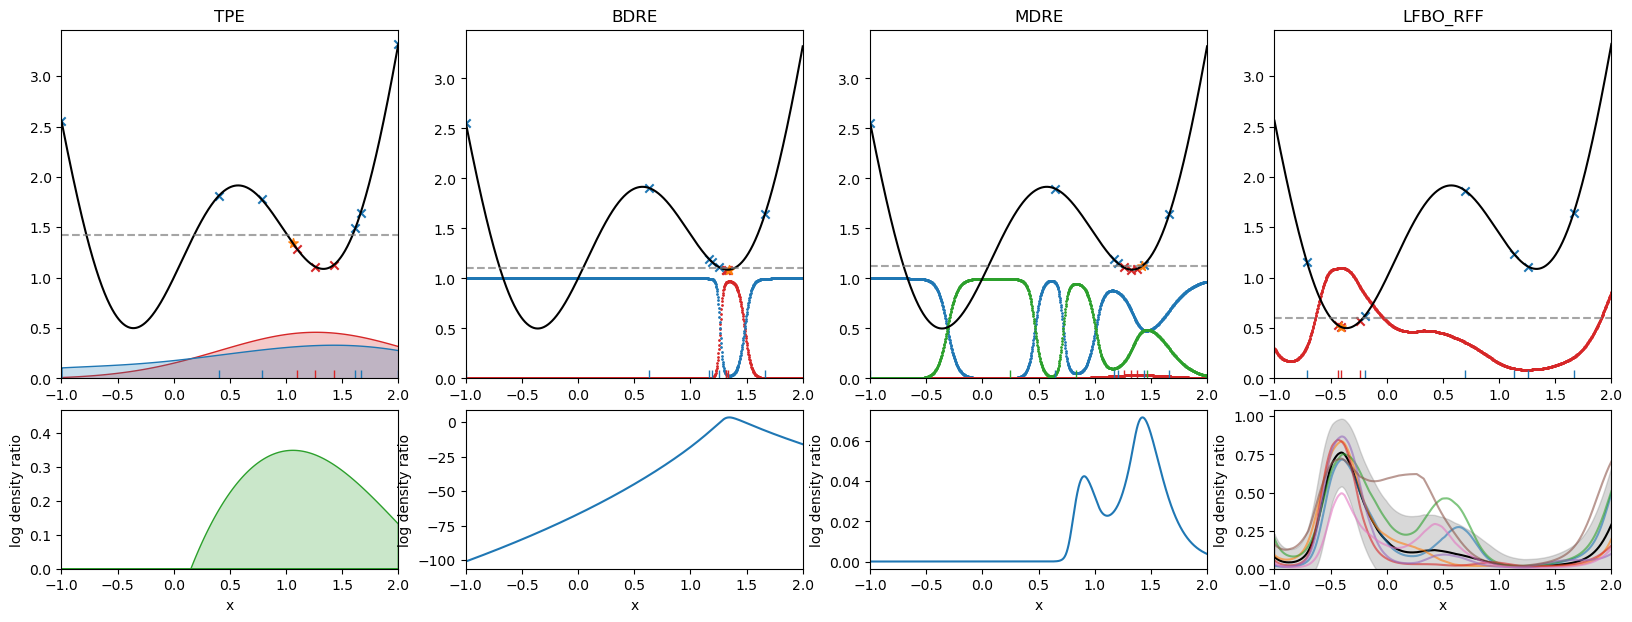

100%|██████████| 500/500 [00:01<00:00, 386.72it/s]


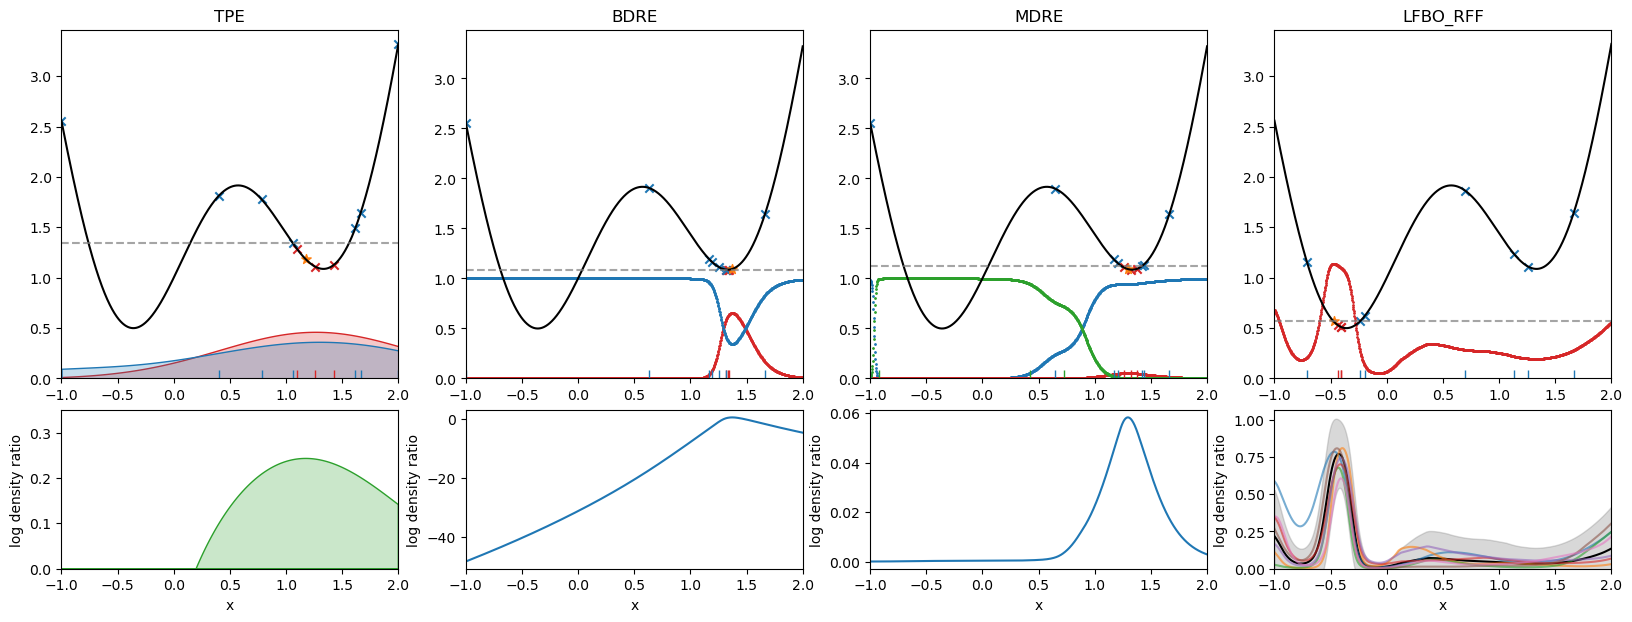

100%|██████████| 500/500 [00:01<00:00, 408.65it/s]
/home/paj7rng/miniconda3/envs/mobo/lib/python3.11/site-packages/botorch/optim/optimize.py:583: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


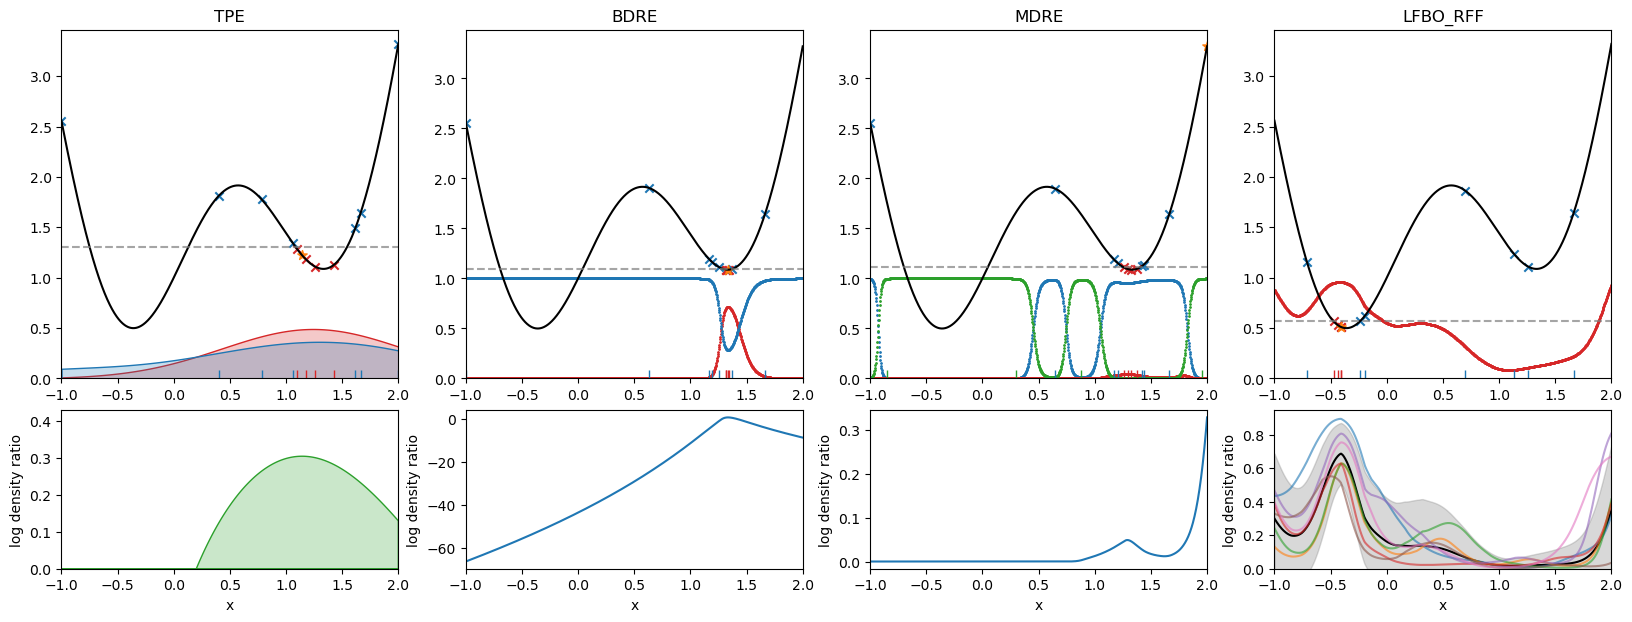

100%|██████████| 500/500 [00:01<00:00, 415.32it/s]


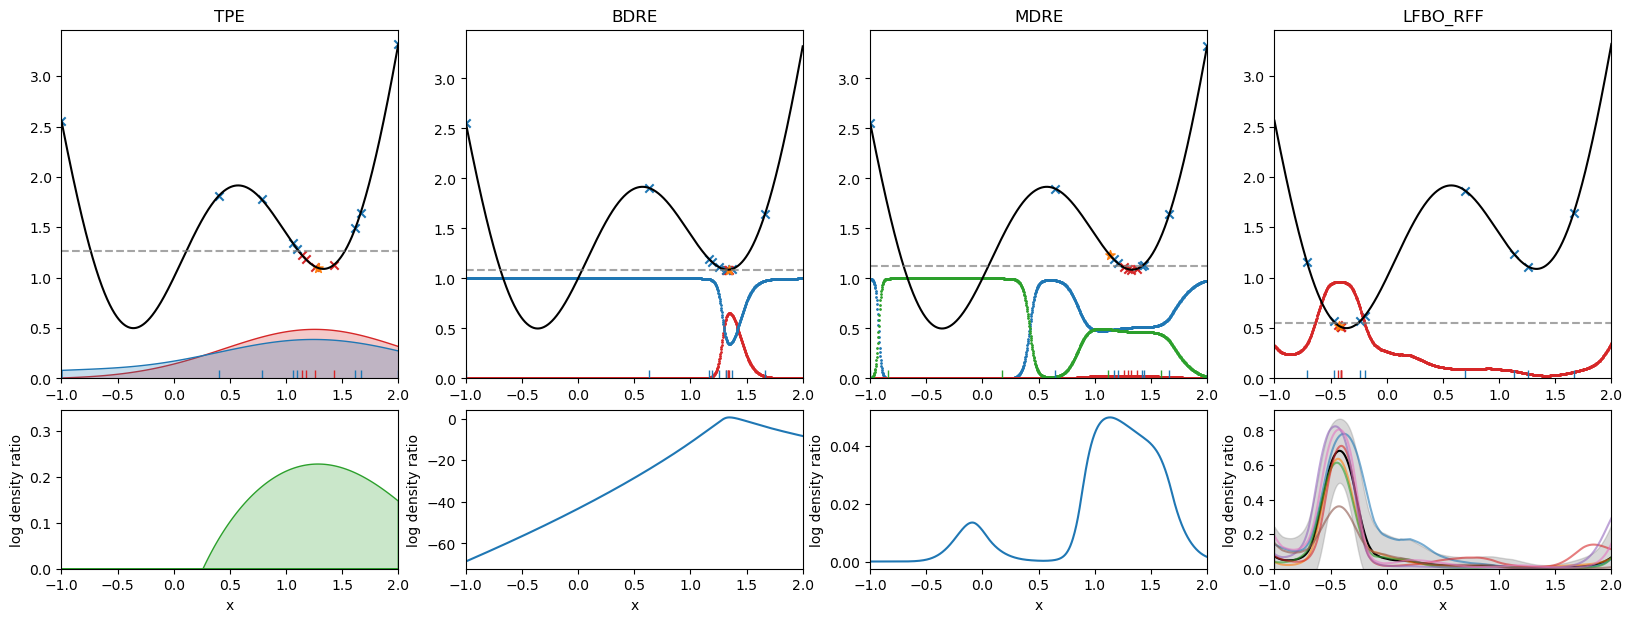

100%|██████████| 500/500 [00:01<00:00, 404.36it/s]


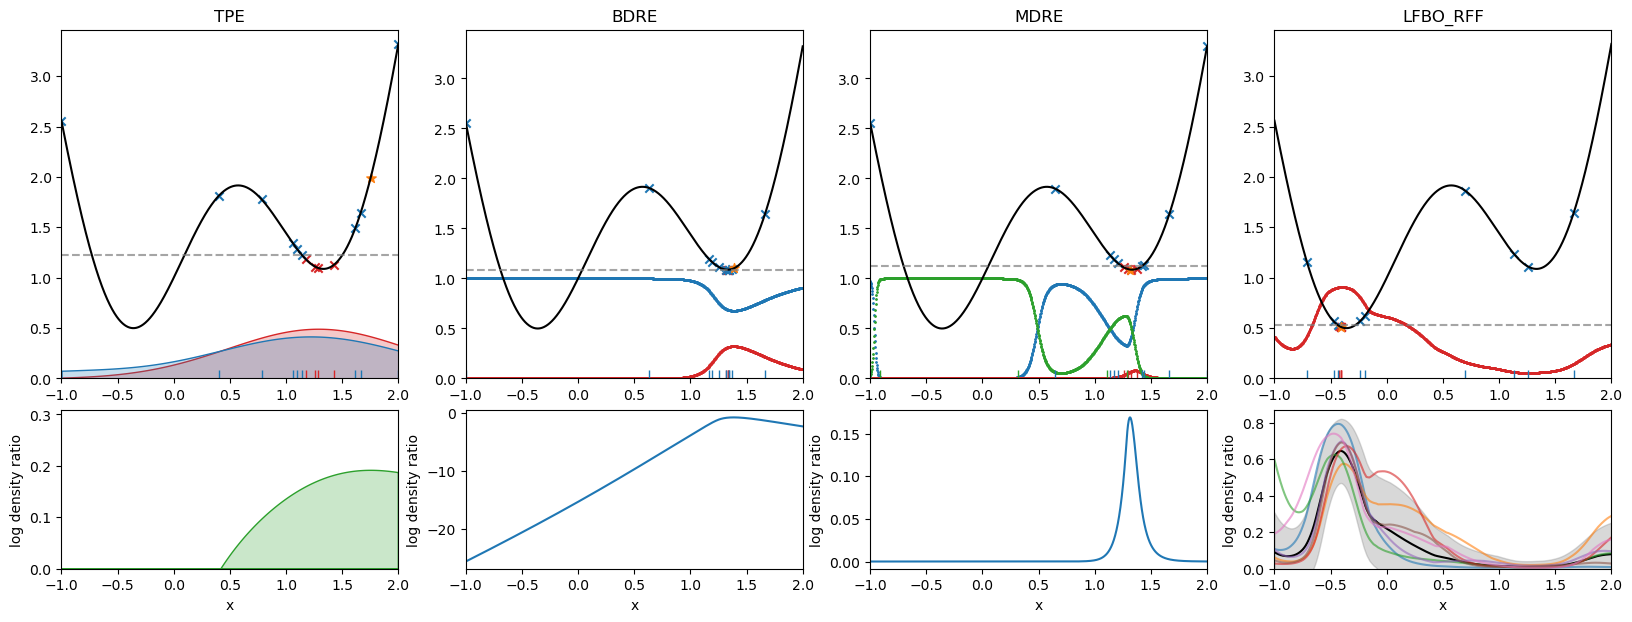

100%|██████████| 500/500 [00:01<00:00, 389.67it/s]


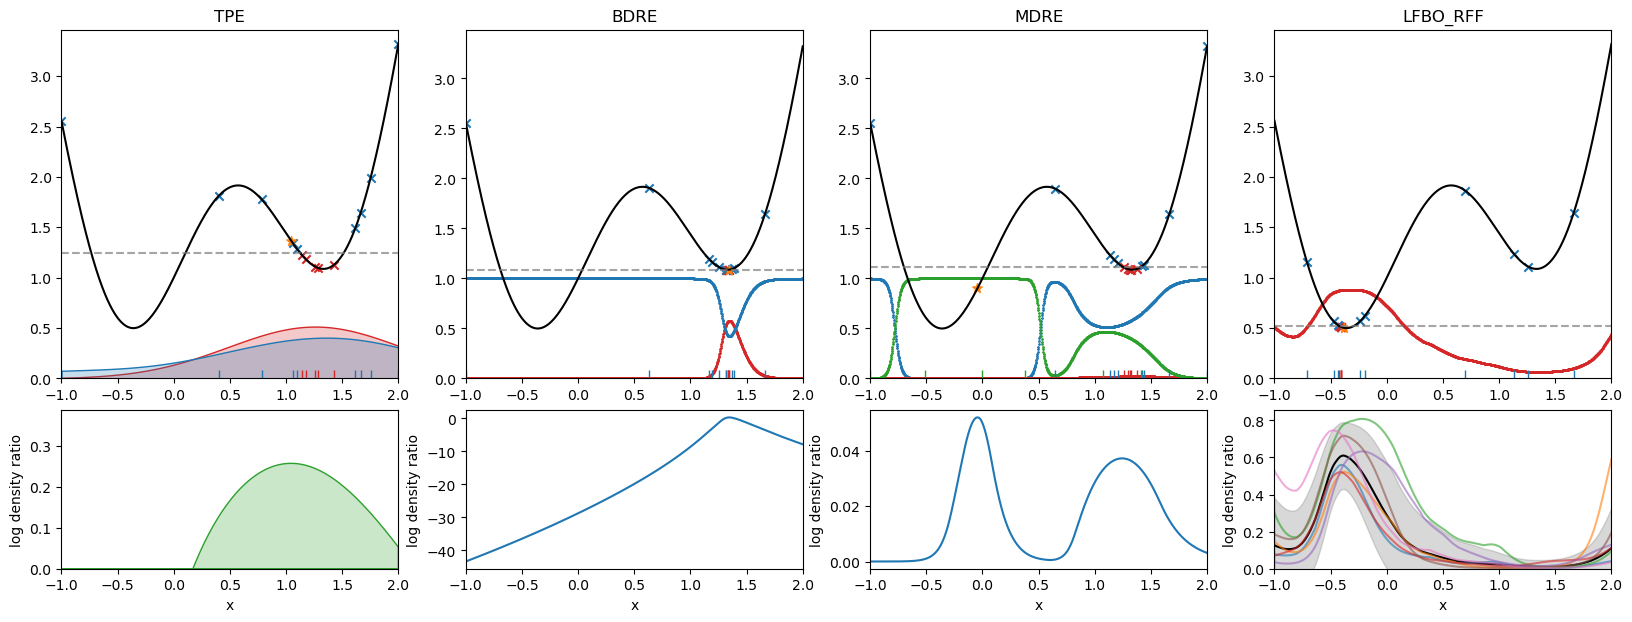

100%|██████████| 500/500 [00:01<00:00, 372.63it/s]


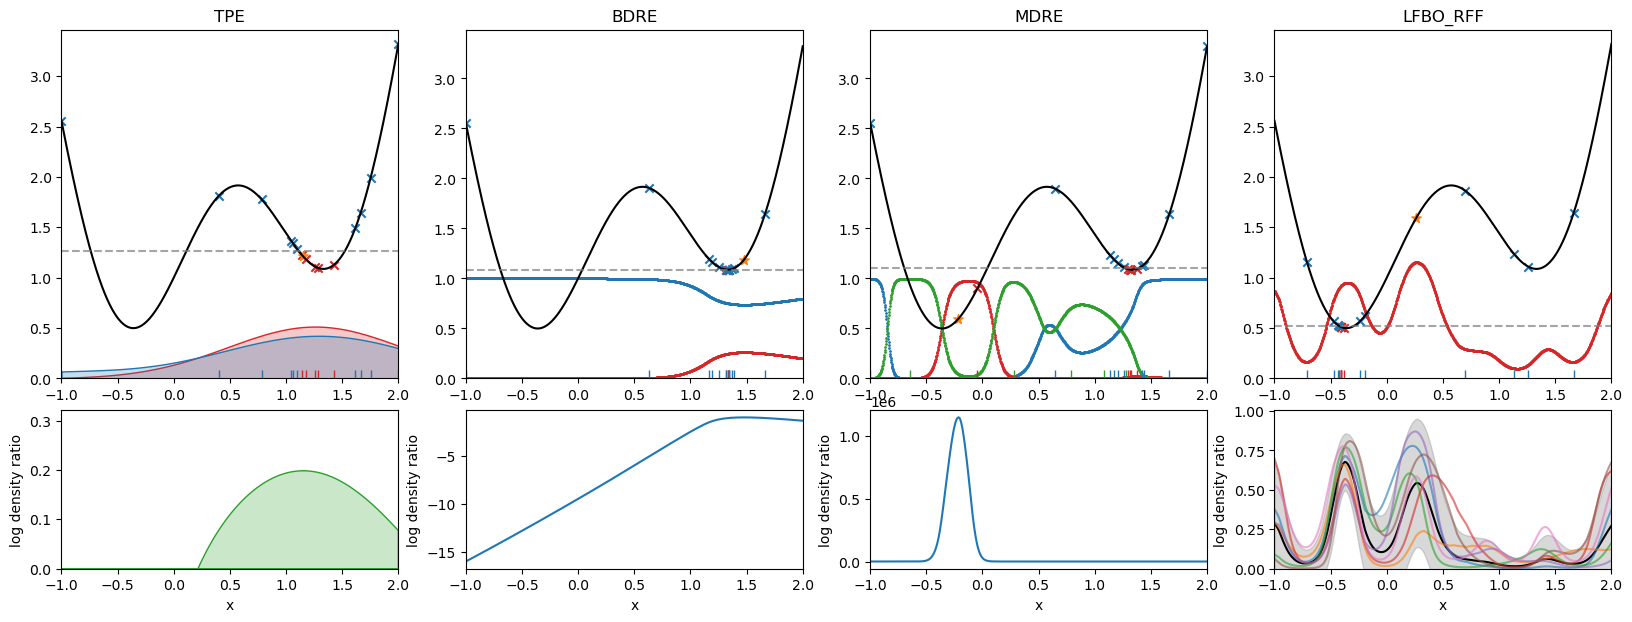

100%|██████████| 500/500 [00:01<00:00, 389.31it/s]


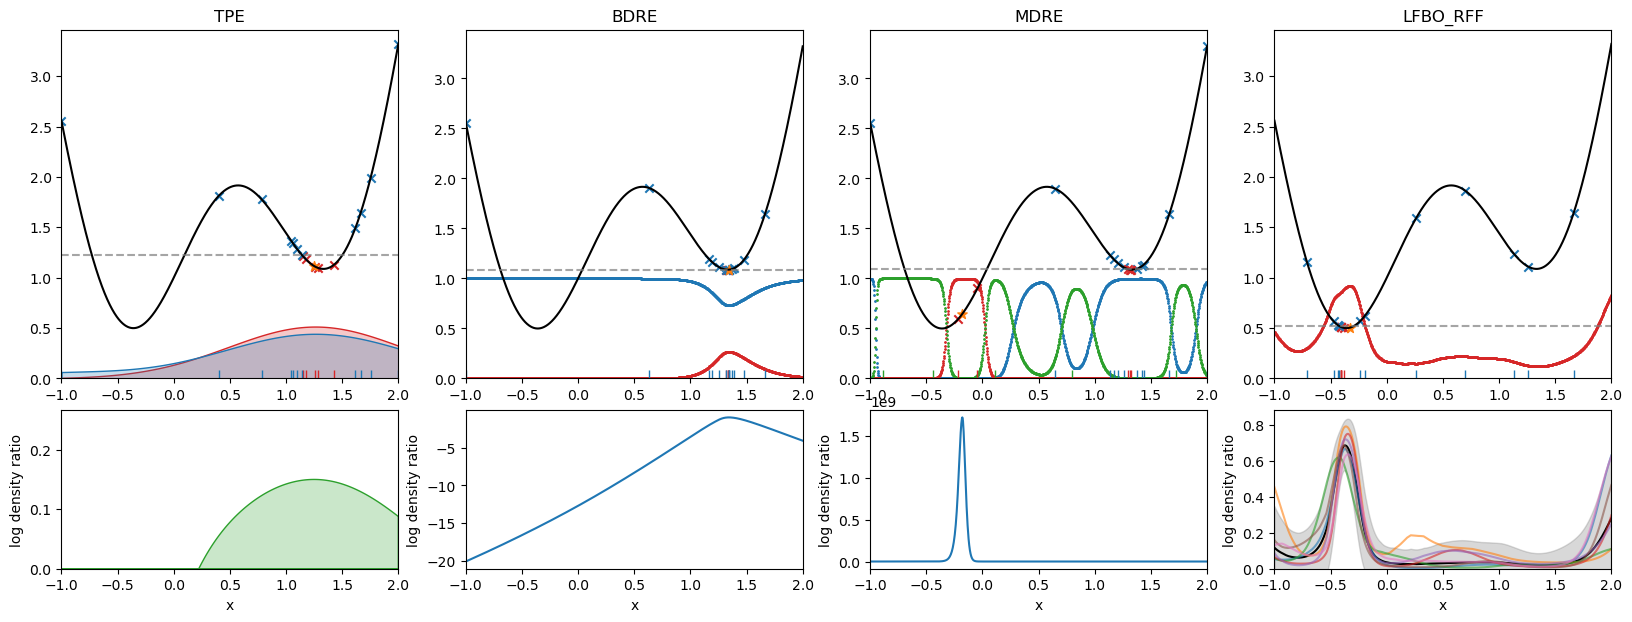

100%|██████████| 500/500 [00:01<00:00, 451.38it/s]


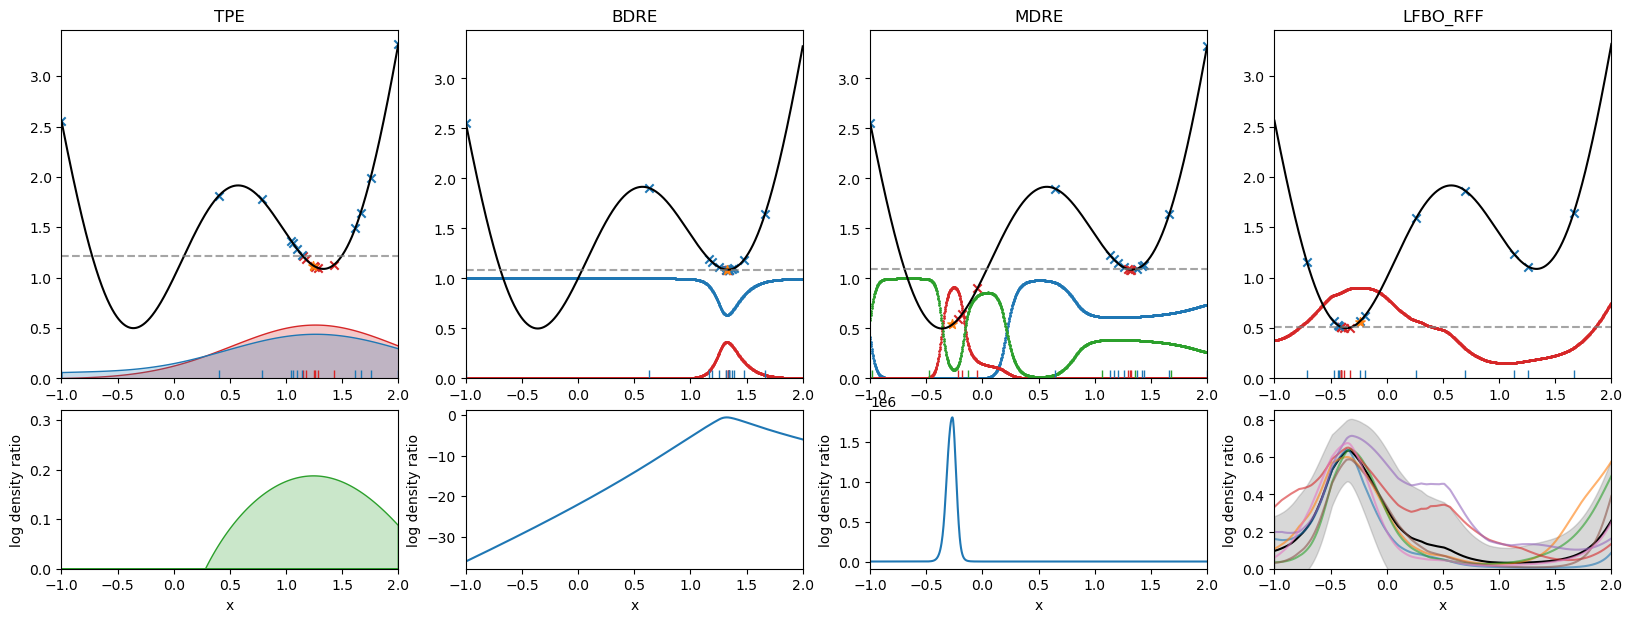

100%|██████████| 500/500 [00:01<00:00, 419.94it/s]


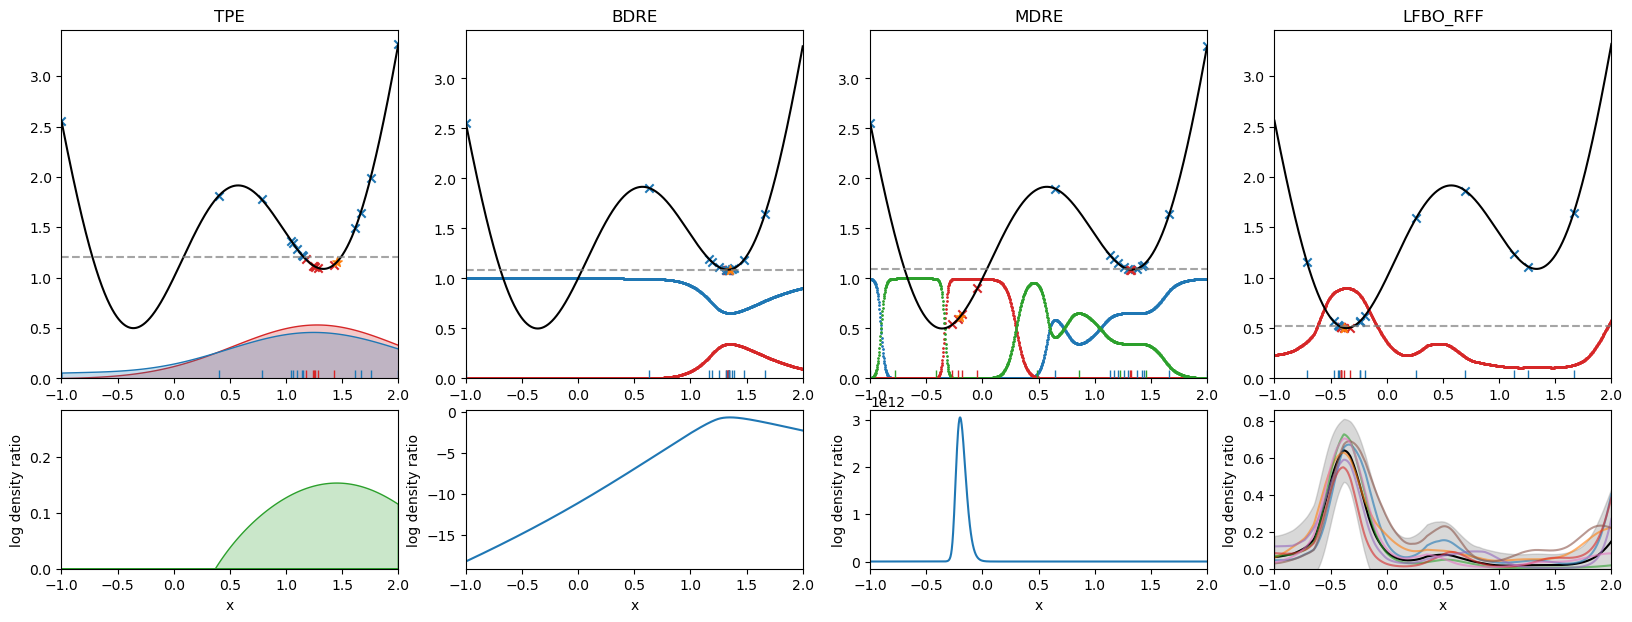

100%|██████████| 500/500 [00:01<00:00, 398.12it/s]


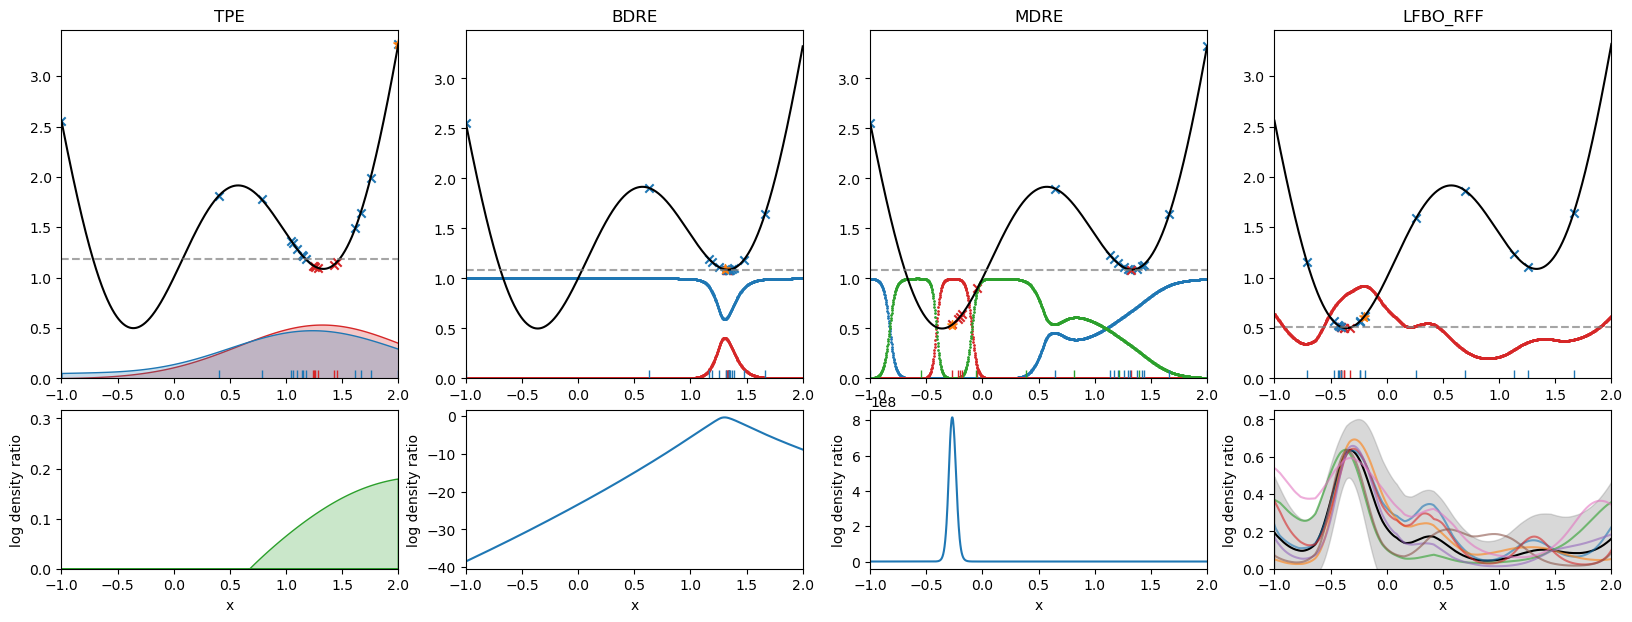

100%|██████████| 500/500 [00:01<00:00, 420.46it/s]


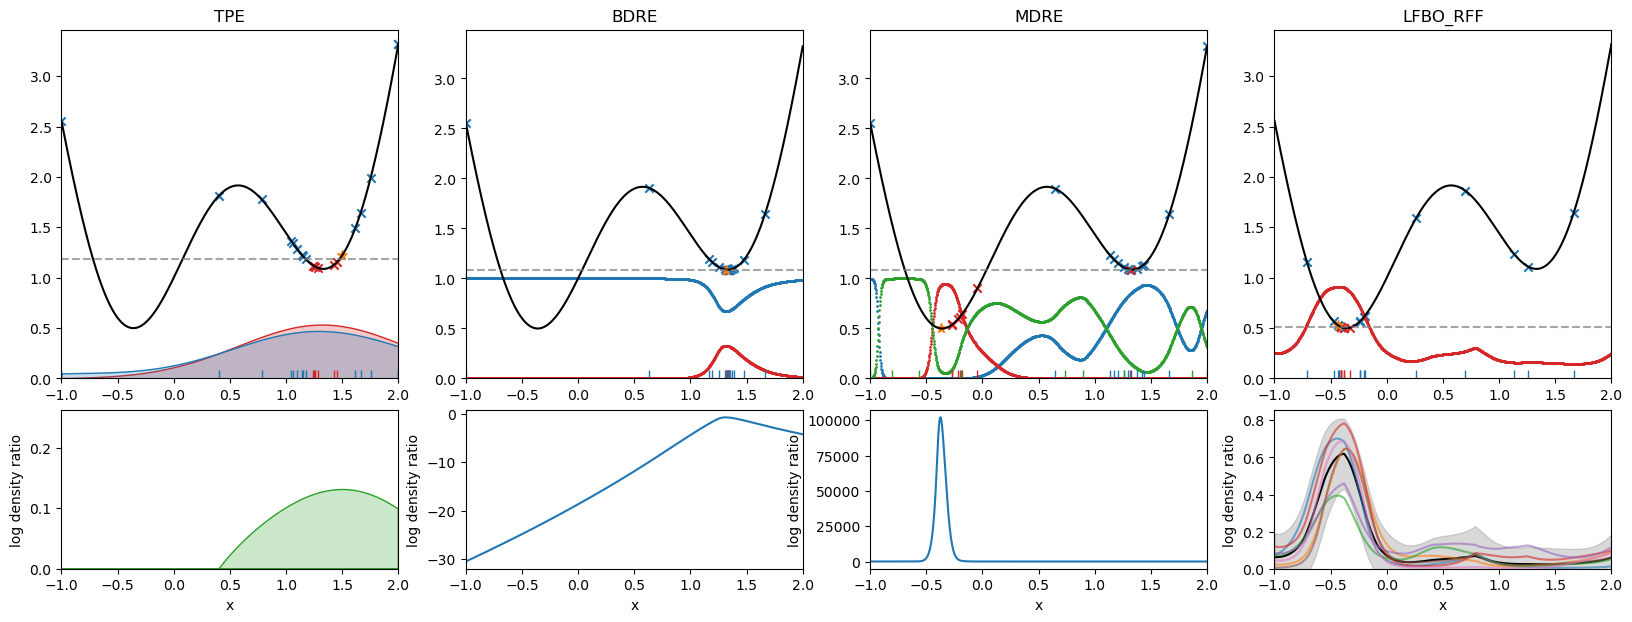

100%|██████████| 500/500 [00:01<00:00, 392.92it/s]


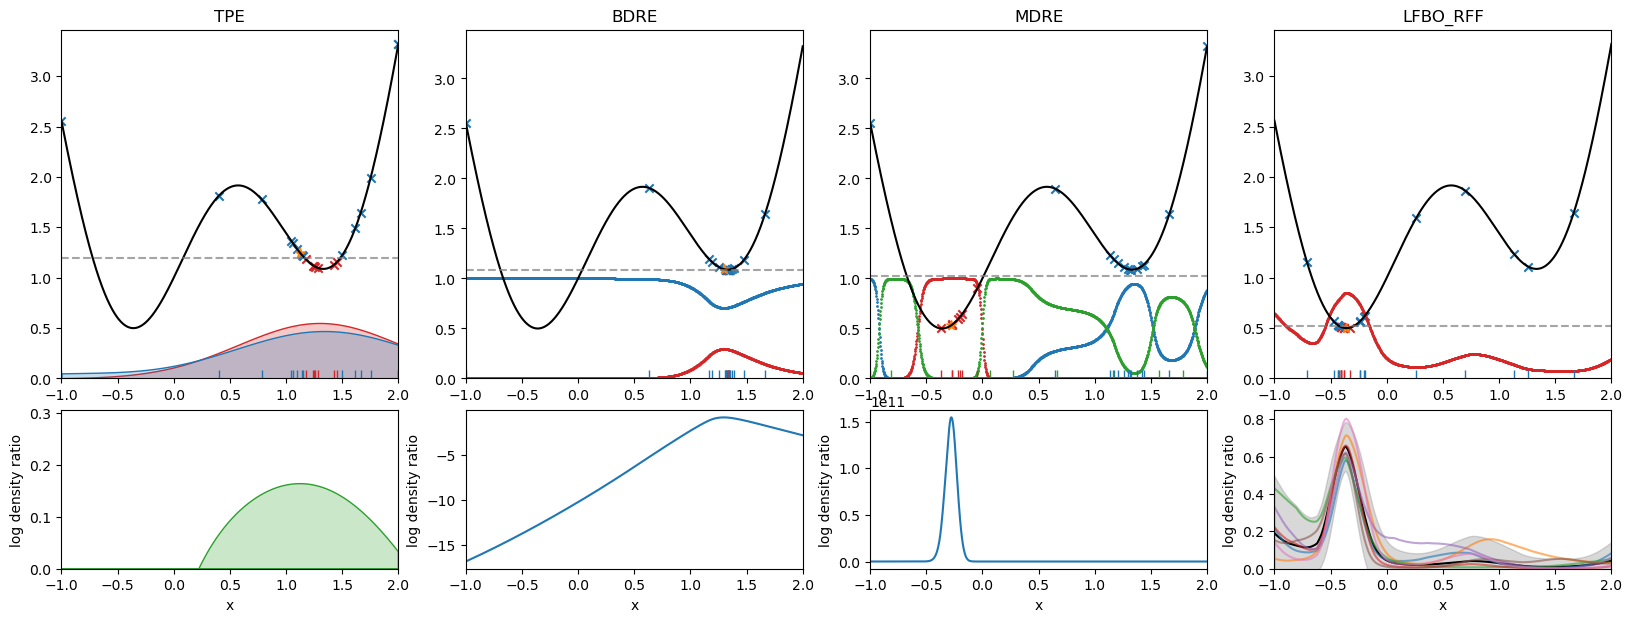

In [10]:
X_obs = np.random.uniform(1, 2, (2,1))
y_obs = forrester(X_obs, noise=False)

X_obs_tpe, y_obs_tpe = X_obs, y_obs
X_obs_bdre, y_obs_bdre = X_obs, y_obs
X_obs_mdre, y_obs_mdre = X_obs, y_obs
X_obs_rff, y_obs_rff = X_obs, y_obs

num_evaluations = 20
GAMMA = 1 / 3

for n in range(num_evaluations):
    
    fig = plt.figure(figsize=(20, 7))
    ax_func_tpe = plt.subplot2grid((3, 4), (0, 0), rowspan=2)
    ax_acf_tpe = plt.subplot2grid((3, 4), (2, 0), rowspan=1)
    ax_func_bdre = plt.subplot2grid((3, 4), (0, 1), rowspan=2)
    ax_acf_bdre = plt.subplot2grid((3, 4), (2, 1), rowspan=1)
    ax_func_mdre = plt.subplot2grid((3, 4), (0, 2), rowspan=2)
    ax_acf_mdre = plt.subplot2grid((3, 4), (2, 2), rowspan=1)
    ax_func_lfbo = plt.subplot2grid((3, 4), (0, 3), rowspan=2)
    ax_acf_lfbo = plt.subplot2grid((3, 4), (2, 3), rowspan=1)

    # tpe
    tpe = TPE(kernel='gaussian')
    X_obs_tpe, y_obs_tpe, z_obs_tpe, tau = split_good_bad(X_obs_tpe, y_obs_tpe, gamma=GAMMA)
    tpe.fit(X_obs_tpe, y_obs_tpe, z_obs_tpe)
    acf_tpe = tpe.predict(dense_x)
    new_x = dense_x[np.argmax(acf_tpe)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_tpe(X_obs_tpe, y_obs_tpe, z_obs_tpe, new_x, new_y, tau, acf_tpe, ax_func_tpe, ax_acf_tpe)
    X_obs_tpe = np.concatenate([X_obs_tpe, new_x.reshape(-1, 1)])
    y_obs_tpe = np.concatenate([y_obs_tpe, new_y.reshape(-1, 1)])

    # bdre
    # X_obs_bdre, y_obs_bdre, z_obs_bdre, tau = split_good_bad(X_obs_bdre, y_obs_bdre, gamma=GAMMA)
    X_train_bdre, y_train_bdre, z_train_bdre, bdre_weight, tau = prepare_data_bdre(X_obs_bdre, y_obs_bdre, gamma=GAMMA)
    bdre = BDRE(input_dim=1, output_dim=2, **tkwargs)
    bdre.fit(X_train_bdre, z_train_bdre, bdre_weight, S=500)
    bdre_preds = bdre.predict(torch.from_numpy(dense_x))
    dr_bdre = (bdre_preds[:, 0] - bdre_preds[:, 1]).numpy()
    acf_bdre = torch.nn.functional.softmax(bdre_preds, dim=-1).numpy()
    new_x = dense_x[np.argmax(dr_bdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_bdre(X_train_bdre, y_train_bdre, z_train_bdre, new_x, new_y, tau, dr_bdre, acf_bdre, ax_func_bdre, ax_acf_bdre)
    X_obs_bdre = np.concatenate([X_obs_bdre, new_x.reshape(-1, 1)])
    y_obs_bdre = np.concatenate([y_obs_bdre, new_y.reshape(-1, 1)])
    
    # mdre
    # X_obs_mdre, y_obs_mdre, z_obs_mdre, tau = split_good_bad(X_obs_mdre, y_obs_mdre, gamma=GAMMA)
    X_train_mdre, y_train_mdre, z_train_mdre, mdre_weight, tau = prepare_data_mdre(X_obs_mdre, y_obs_mdre, gamma=GAMMA)
    mdre = MDRE(input_dim=1, output_dim=3, **tkwargs)
    mdre.fit(X_train_mdre, z_train_mdre, mdre_weight, S=500)
    mdre_preds = mdre.predict(torch.from_numpy(dense_x))
    acf_mdre = torch.nn.functional.softmax(mdre_preds, dim=-1).numpy()
    dr_mdre = acf_mdre[:, 0] / acf_mdre[:, 1]
    # dr_mdre = (mdre_preds[:, 0] - mdre_preds[:, 1]).numpy()
    new_x = dense_x[np.argmax(dr_mdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_mdre(X_train_mdre, y_train_mdre, z_train_mdre, new_x, new_y, tau, dr_mdre, acf_mdre, ax_func_mdre, ax_acf_mdre)
    X_obs_mdre = np.concatenate([X_obs_mdre, new_x.reshape(-1, 1)])
    y_obs_mdre = np.concatenate([y_obs_mdre, new_y.reshape(-1, 1)])

    # lfbo_rff
    lfbo = RFF_MLP(input_dim=1, output_dim=1, dropout_rate=0.0, num_hidden_units=32, num_rffs=256, num_hidden_layers=2, **tkwargs)
    lfbo.to(**tkwargs)
    lfbo.fit(torch.from_numpy(X_obs_rff), torch.from_numpy(y_obs_rff), gamma=GAMMA, S=50)
    acq_func = qUpperConfidenceBound(lfbo, beta=9.0, weights=torch.tensor([1.0], **tkwargs), sampler=None)
    with torch.no_grad():
        posterior = lfbo.posterior(torch.from_numpy(dense_x))
        acq_values = acq_func(torch.from_numpy(dense_x).unsqueeze(1))
        acf_mean = posterior.mean.numpy()
        acf_samples = acq_func.get_posterior_samples(posterior).squeeze(1)

    new_x, _ = optimize_acqf(
        acq_func,
        bounds=torch.tensor([[-1.], [2.]], **tkwargs),
        q=1,
        sequential=True,
        num_restarts=5,
        raw_samples=512,
    )
    new_y = forrester(new_x, noise=False)
    plot_step_through_lfbo(X_obs_rff, y_obs_rff, new_x, new_y, acf_mean, acf_samples, ax_func_lfbo, ax_acf_lfbo)
    ax_func_lfbo.scatter(dense_x, acq_values, s=1, color='tab:red',)
    X_obs_rff = np.concatenate([X_obs_rff, new_x.numpy().reshape(-1, 1)])
    y_obs_rff = np.concatenate([y_obs_rff, new_y.numpy().reshape(-1, 1)])

    plt.show()

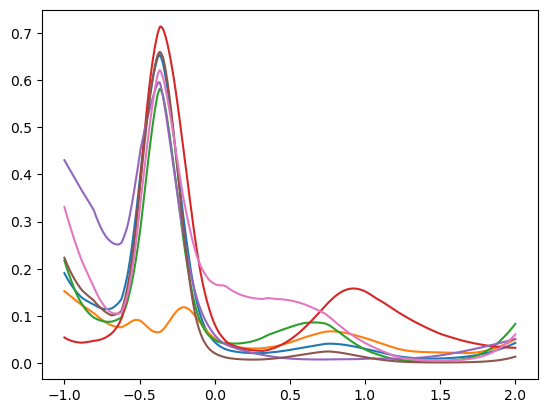

In [11]:
# switch q and b dimension
X = torch.from_numpy(dense_x).unsqueeze(1)
X = X.transpose(0, 1)

with torch.no_grad():
    posterior = acq_func.model.posterior(X)
    samples = acq_func.get_posterior_samples(posterior)  # n x b x q x o
    scalarized_samples = samples.matmul(acq_func.weights)  # n x b x q
    mean = posterior.mean  # b x q x o
    scalarized_mean = mean.matmul(acq_func.weights)  # b x q
    scalarized_std = scalarized_samples.std(dim=0)
    # return (scalarized_mean + self.beta.sqrt() * scalarized_std).squeeze()
plt.plot(X.squeeze(), scalarized_mean.squeeze())
plt.plot(X.squeeze(), scalarized_std.squeeze())
for i in range(5):
    plt.plot(X.squeeze(), samples[i].squeeze())